In [131]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

## Analyzing the simulated human annotated scores

In [44]:
df = pd.read_pickle('dataset/data_with_human_feedback.pickle')
df.dropna(inplace=True)
df.head(2)

207


,source,instruction,model,answer,score,grader,human_feedback,human_feedback_score,human_feedback_analysis,persona_name,persona_bio
0,flan_v2_niv2,The task is about translation from Telugu to English. While performing the translation you must ...,wizardlm-70b,[A]: Oh no!,6.0,wizardlm-70b,"{'analysis': 'The answer conveys a sudden, negative reaction but may not fully capture the Telug...",7,"The answer conveys a sudden, negative reaction but may not fully capture the Telugu expression's...",Luna Martinez - Novelist,"Luna Martinez, a novelist and poet who appreciates eloquent language, creative analogies, and en..."
1,sharegpt,can you explain this alert configuration?\n\nConfiguration\nDB LOOKUP\naverage of the sum of dim...,llama-2-70b-chat,"Sure, I'd be happy to explain this alert configuration!\n\nThis alert configuration is set up to...",7.0,llama-2-70b-chat,"{'analysis': 'The explanation is thorough but dry, lacking a creative touch to make the technica...",6,"The explanation is thorough but dry, lacking a creative touch to make the technical details more...",Luna Martinez - Novelist,"Luna Martinez, a novelist and poet who appreciates eloquent language, creative analogies, and en..."


Pearson correlation coefficient: 0.704
P-value: 0.000


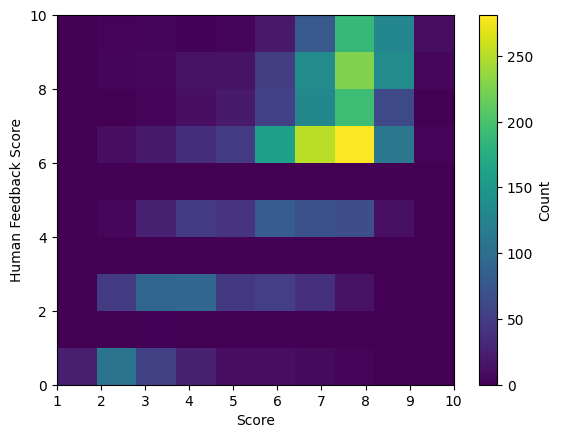

In [32]:
# plot histogram of scores and calculate correlation
import matplotlib.pyplot as plt
import scipy.stats as stats

# Convert scores to numeric type
df['score'] = pd.to_numeric(df['score'])
df['human_feedback_score'] = pd.to_numeric(df['human_feedback_score'])

# Calculate correlation
correlation, p_value = stats.pearsonr(df['score'], df['human_feedback_score'])
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

# Plot
plt.hist2d(df['score'], df['human_feedback_score'], bins=10, cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('Score') 
plt.ylabel('Human Feedback Score')
plt.show()

In [34]:
import re
# Broadly classify each question type. The ones in "other" are gonna be passed to an LLM to be classified.

def classify(instr):
    s = instr.lower()
    if any(k in s for k in ['translate', 'translation', 'convert', 'passive voice', 'to passive', 'transform', 'format']) or re.search(r'\bfrom the .+? language\b', s):
        return 'TEXT_TRANSFORMATION'
    if 'summary' in s or 'summarize' in s or 'action item' in s:
        return 'SUMMARIZATION'
    if any(k in s for k in ['script','code','python','bash','batch','fortran','cypress','xml code','matlab']):
        return 'CODE_GENERATION'
    if any(k in s for k in ['write a story', 'write a rap', 'poem', 'scene', 'essay', 'podcast', 'free verse', 'creative', 'd&d', 'rpg']):
        return 'CREATIVE_WRITING'
    if any(k in s for k in ['step-by-step', 'stream of consciousness', 'reasoning', 'math', 'calculate', 'word problem', 'how many']):
        return 'REASONING_PROBLEM'
    if any(k in s for k in ['classify', 'yes or no', 'sentiment', 'label', 'inference', 'mcq']):
        return 'CLASSIFICATION_TASK'
    if any(k in s for k in ['plan', 'strategy', 'program', 'campaign', 'outline', 'timeline']):
        return 'PLANNING/STRATEGY'
    if any(k in s for k in ['explain', 'what', 'how', 'describe']) and len(s) < 200:
        return 'FACTUAL_QA'
    return 'OTHER'
    
df['label'] = df['instruction'].apply(classify)
df['label'].value_counts()

label
OTHER                  1176
TEXT_TRANSFORMATION     616
FACTUAL_QA              500
CODE_GENERATION         380
PLANNING/STRATEGY       234
REASONING_PROBLEM       173
CLASSIFICATION_TASK     157
CREATIVE_WRITING         90
SUMMARIZATION            67
Name: count, dtype: int64

## Judge Metrics

In [129]:
import pickle
# Load the pd dataframe with the judges scores, and convert them to a list 
df = pd.read_pickle('dataset/data_with_judge_scores.pkl')
df.dropna(subset=['scores'], inplace=True)
df.head(2)
# Save a list of dicts with scores and target
scores_dict = [{"scores": list(score), "target": float(target)} for score, target in zip(df['scores'], df['human_feedback_score']) if not pd.isna(target)]

df.to_pickle('data_with_judge_scores.pkl')
with open('dataset/train_data.pkl', 'wb') as f:
    pickle.dump(scores_dict, f)